In [45]:
import time
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import matplotlib
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 123
learning_rate = 0.1
num_epochs = 25
batch_size = 256

# Architecture
num_features = 784
num_classes = 10


##########################
### MNIST DATASET
##########################

train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)


# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape) #NCHW
    print('Image label dimensions:', labels.shape)
    break

100%|██████████| 9.91M/9.91M [00:00<00:00, 123MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 35.5MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 32.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.31MB/s]


Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


In [34]:
class SoftmaxRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)

        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()

    def forward(self, x):
        logits = self.linear(x)
        return logits

    def compute_accuracy_and_loss(self, data_loader,device):
      correct_preds=0
      total_preds=0
      avg_loss=0
      total_batches=0
      for batch_idx,(inputs,targets) in enumerate(data_loader):
        inputs=inputs.reshape(-1,28*28).to(device)
        targets=targets.to(device)
        logits=self.forward(inputs)
        avg_loss+=F.cross_entropy(logits,targets)
        total_batches+=1
        preds=F.softmax(logits,dim=1)
        _, preds = torch.max(preds, 1)
        correct_preds+=torch.sum(preds==targets)
        total_preds+=len(preds)
      accuracy=correct_preds/total_preds
      avg_loss/=total_batches
      return accuracy,avg_loss

    def train(self,train_loader,num_epochs,lr,device):
      loss_arr=[]
      torch.manual_seed(123)
      optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)

      for epoch in range(num_epochs):
        avg_cost=0
        for batch_idx,(inputs,targets) in enumerate(train_loader):
          inputs=inputs.reshape(-1,28*28).to(device)
          targets=targets.to(device)
          logits=self.forward(inputs)
          loss=F.cross_entropy(logits,targets)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        with torch.no_grad():
          epoch_accuracy,epoch_loss=self.compute_accuracy_and_loss(train_loader,device)
          print(f"Epoch {epoch} \t Loss: {epoch_loss} \t Training Accuracy: {epoch_accuracy}")




In [35]:
model = SoftmaxRegression(num_features=num_features,
                          num_classes=num_classes)

model.to(device)

SoftmaxRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [36]:
model.train(train_loader=train_loader,num_epochs=10,lr=0.01,device=device)

Epoch 0 	 Loss: 0.4709162712097168 	 Training Accuracy: 0.8805166482925415
Epoch 1 	 Loss: 0.3985048532485962 	 Training Accuracy: 0.8926500082015991
Epoch 2 	 Loss: 0.3692842423915863 	 Training Accuracy: 0.8994166851043701
Epoch 3 	 Loss: 0.3514530062675476 	 Training Accuracy: 0.902899980545044
Epoch 4 	 Loss: 0.33831819891929626 	 Training Accuracy: 0.906083345413208
Epoch 5 	 Loss: 0.33036160469055176 	 Training Accuracy: 0.9083166718482971
Epoch 6 	 Loss: 0.3238169848918915 	 Training Accuracy: 0.9100833535194397
Epoch 7 	 Loss: 0.3179059624671936 	 Training Accuracy: 0.9120500087738037
Epoch 8 	 Loss: 0.31197986006736755 	 Training Accuracy: 0.9131500124931335
Epoch 9 	 Loss: 0.3082396388053894 	 Training Accuracy: 0.9145833253860474


In [43]:
test_accuracy,test_loss=model.compute_accuracy_and_loss(test_loader,device)
print(f"test_accuracy {test_accuracy*100:.3f}")

test_accuracy 91.640


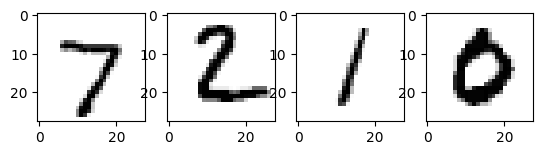

In [46]:
for features, targets in test_loader:
    break

fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(features[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [47]:
predictions = model.forward(features[:4].reshape(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions)

Predicted labels tensor([7, 2, 1, 0])
